#### Week 2: Building Advanced RAG Applications.  Authored by Chris Sanchez.

# Week 2 - Notebook 5

# Overview

Welcome to Notebook 5, we can see the light at the end of the tunnel in our RAG dataflow ☀️...we are at the final step before displaying our results to the end user in a Streamlit UI.  In this notebook we'll cover setting up a connection with our LLM of choice through the `litellm` package and round it out with an initial baseline evaluation of our entire system.  

#### Week Two
* ~Part 4~:
  * ~Add Hybrid Search and ReRanker to the mix (new benchmark)~
* **Part 5 (THIS NOTEBOOK)**:
  * **LLM Integration & Evaluation**

![arch_diagram]( 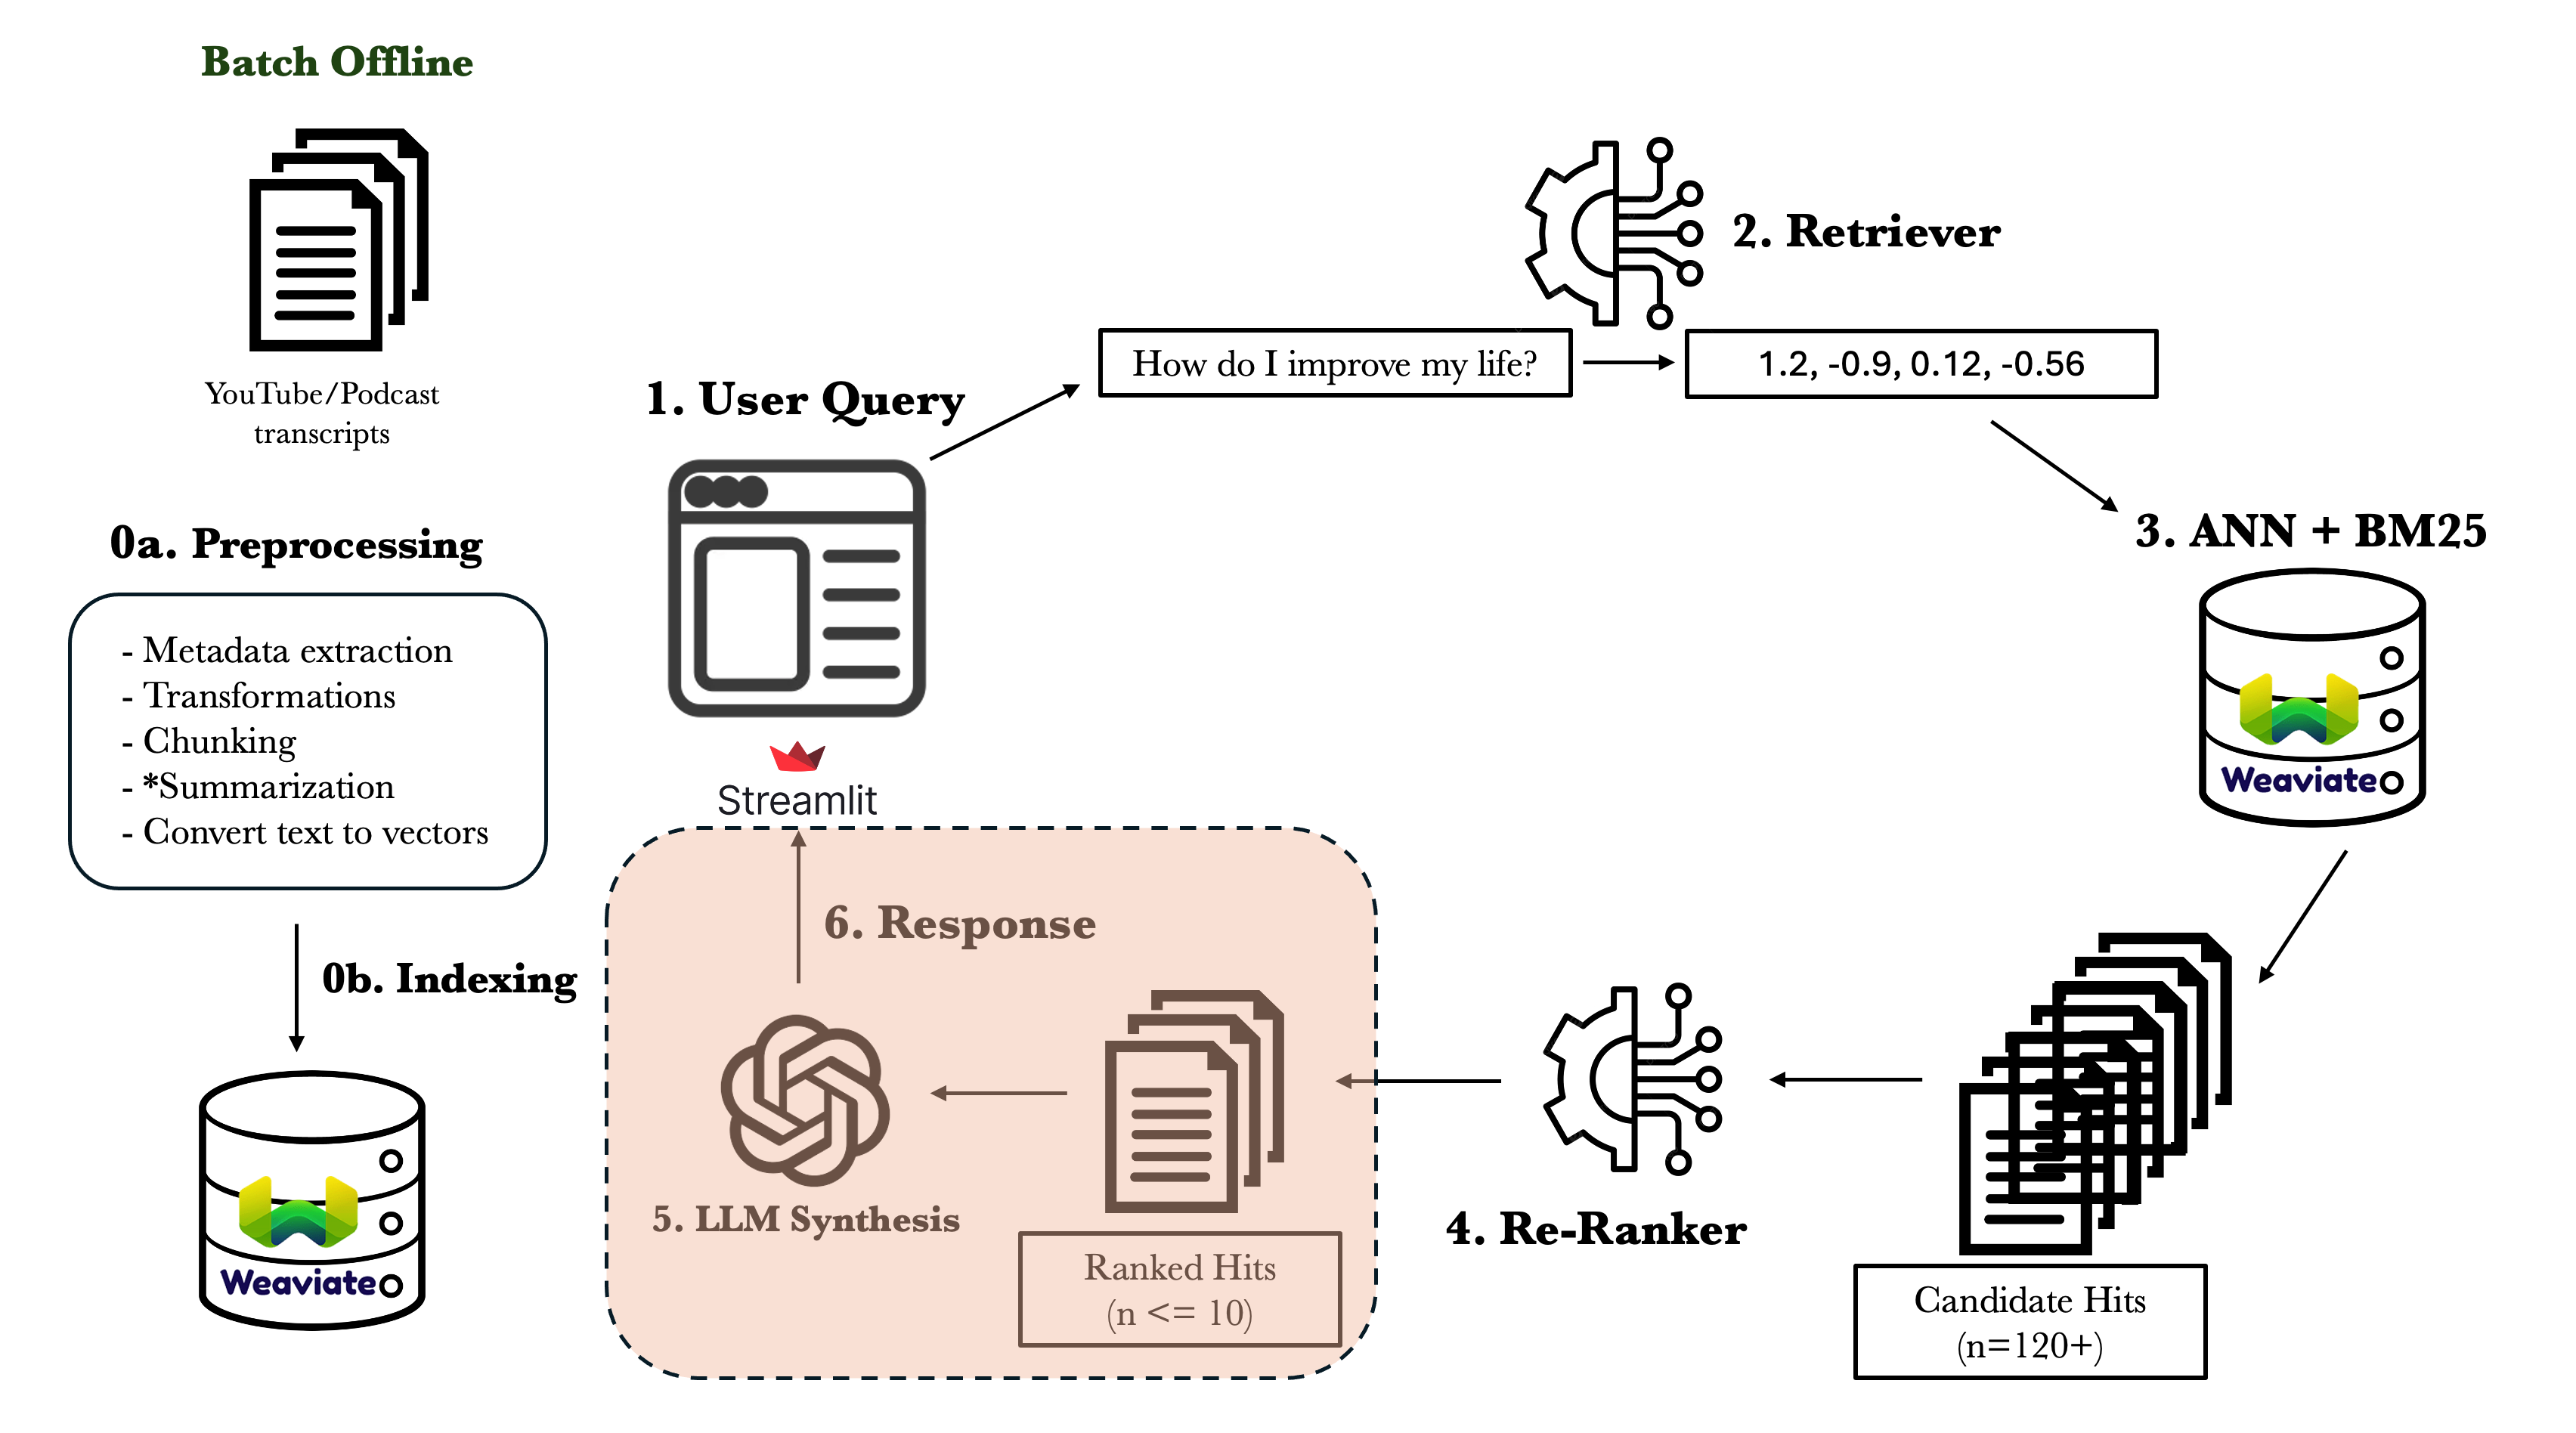)

### Notebook Highlights
In this notebook we'll cover the following topics:
1. Crafting our RAG system message
2. Crafting our RAG user message
3. Making chat completions using the `litellm` framework
4. Build a `Callable` RAG pipeline
5. Introduction to the `DeepEval` LLM evaluation framework
6. Get a baseline score for our LLM Answer Generation

💥 Let's get STARTED! 💥

In [ ]:
import sys
sys.path.append('../')

from dotenv import load_dotenv, find_dotenv
envs = load_dotenv(find_dotenv(), override=True)

from warnings import filterwarnings
filterwarnings('ignore')

from src.database.weaviate_interface_v4 import WeaviateWCS
from src.llm.llm_interface import LLM
from src.llm.llm_utils import get_token_count
from src.llm.prompt_templates import (huberman_system_message, 
                                      question_answering_user_message,
                                      generate_prompt_series)
from src.preprocessor.preprocessing import FileIO
from src.reranker import ReRanker
from litellm import ModelResponse

from tqdm import tqdm
from typing import Literal
from rich import print
import os

### Set Constants

In [ ]:
retriever = WeaviateWCS(os.environ['WEAVIATE_ENDPOINT'], os.environ['WEAVIATE_API_KEY'])
reranker = ReRanker()
collections = retriever.show_all_collections()

In [ ]:
#define collection_name
print(collections)
collection_name = None

In [ ]:
#use question bank from previous notebook
queries = ['How to fight age-related muscle loss', 
           'How can listeners support the Huberman Lab podcast', 
           'What is the role of the mid-singulate cortex in the human brain', 
           'Why is sleep so important to maximizing healthspan']

#### Gather initial reranked responses for our queries.  We'll use these later in the notebook

In [ ]:
%%time
#1st-Stage Retrieval: Deep search over 200 documents
responses = [retriever.hybrid_search(q, collection_name, alpha=0.25, limit=200) for q in queries]

#2nd-Stage Reranking: keeping only top-3 results
reranked = [reranker.rerank(resp, queries[i], top_k=3) for i,resp in enumerate(responses)]

## Discussion
***

Alright, the stage is now set, we have obtained our reranked results and now we are ready to feed them into our LLM for synthesis.  We've completed the **Retrieval** part of RAG, now it's time to Augment the Generation of an answer using those results...but how exactly?

As we've already discussed, effective RAG depends heavily on the quality of the retrieved material.  Hopefully, by now as you've worked through Notebooks 3 and 4, you feel confident that you've built a top-notch system, one that can deliver the best possible results given the corpus you have to work with.  What's left to do now, is feed those results into the LLM as context so the model can perform its job of answer synthesis, this task is primarily accomplished through **prompt engineering**.  

*** *Side note: I try to stay consistent by using the word "message" for describing LLM input, however, throughout this notebook/course I will refer to both "messages" and "prompts" synonymously.* 

### System Message
***
The system message serves as a directive to the model, providing guidance on how to interpret and respond to subsequent user inputs. If crafted well, the system message not only sets the tone for the interaction but also influences the nature and quality of the model's responses. Therefore, it's essential to ensure that the system message is explicit, detailed, and comprehensive. By providing clear instructions and context, end users can more readily expect that the model will produce the desired outcomes. If you look at the [`src/llm/prompt_templates.py`](https://github.com/americanthinker/rag-applications/blob/main/src/llm/prompt_templates.py) file, you'll see a series of pre-defined message templates for this course.  The primary `system_message` that we'll be using is the `huberman_system_message`:

```
1. You are a repository of knowledge and wisdom about the Huberman Lab podcast.
2. The Huberman Lab podcast is hosted by Dr. Andrew Huberman, a neuroscientist and tenured professor of neurobiology 
   and ophthalmology at Stanford School of Medicine. The podcast discusses neuroscience and science-based tools, 
   including how our brain and its connections with the organs of our body control our perceptions, our behaviors, 
   and our health, as well as existing and emerging tools for measuring and changing how our nervous system works. 
   The podcast is frequently ranked in the top 10 of all podcasts globally and is often ranked #1 in the categories 
   of Science, Education, and Health & Fitness.
3. Your task is to answer questions about the Huberman Lab podcast only using the context provided in the user message.
4. Only use the context provided to answer the question. Do not use any external knowledge or resources to answer the question.
```

The **numbers you see above are not part of the actual prompt**, but I've included them here to act as a guide for this discussion:
1. We are explicitly telling the model what it's primary goal or purpose in life is.
2. We provide the model with some background information about the podcast that will be present with every API call.
3. We eplicitly tell the model what it's primary task will be (this will be repeated again in the user message).
4. Because we are building a RAG system, and presumably don't want the model to generate answers based on what it already *thinks* it knows, we are instructing the LLM to stick to the material presented (to the extent that it will listen 😼).

In [ ]:
#to see the actual prompt without numbers
print(huberman_system_message)

### User Message
***
Here's where it gets interesting...The user message is the focal point of RAG.  It's the entrypoint for feeding our retrieved context (which we worked so hard to curate), into the LLM for consumption.  To enable this context feeding, I've created a user prompt: `question_answering_user_message` and a helper prompt generation function that will take a series of retrieved results and format them properly.  Let's take a look:

```
- 1. Your task is to synthesize and reason over a series of transcripts of an interview between Andrew Huberman and his 
guest(s).  After your synthesis, use the series of transcripts to answer the below question.  The series will be in the 
following format:

- 2. 
-----------------------
Show Summary: <summary>
Show Guest: <guest> 
Transcript: <transcript>
------------------------

- 3. 
Start Series:
------------------------
{series}
------------------------

- 4. 
Question:

{question}

------------------------
- 5.  Answer the question and provide reasoning if necessary to explain the answer.

    1. If the context does not provide enough information to answer the question, then
    state that you cannot answer the question with the provided context.
    2. Do not use any external knowledge or resources to answer the question.
    3. Answer the question directly and {verbosity}.

------------------------
Answer:
```

Again the numbering above is not part of the actual prompt. 
1. We reiterate to the model what it's primary task is and we tell it what to expect given the format of the context.
2. We use a one-shot example of what the series of contexts will look like i.e. Summary, Guest, followed by Transcript chunk.
3. The **series** of context blocks (i.e. our retrieved results) is inserted here. Because we have useful metadata (such as `summary` and `guest`) it makes sense to feed that to the LLM as well for additional context, outside of just the transcript chunk (`content` field).
4. The original query is inserted here as the **question**: this is the end user information need.
5. We follow up with explicit directions on what to do after the LLM has reasoned through the text and reiterate not to use external knowledge (i.e. model weights). We also add a **verbosity** option which effectively controls the length of the model output (which can be adjusted based on our use case).

In [ ]:
#print to see the prompt without numbers
print(question_answering_user_message)

### Assistance Function: Generate a Series for User Prompt
***
The heavy lifting of context insertion and formatting is completed by the [`generate_prompt_series`](https://github.com/americanthinker/rag-applications/blob/main/src/llm/prompt_templates.py#L70) function.  This function insert a results (context) block from the `reranked` variable into the `context_block` string, which is populated by the `create_context_blocks` fucntion.  These blocks are then joined as a series in the prompt generation function. Code examples below show how this is achieved.  When you print out the final result in this example you should see three separate "context blocks" that make up the series. Verbosity options are provided as a natural language means of controlling model output length. 

```
verbosity_options = ['concisely', 'use about four sentences', 'with as much detail as possible, within the limits of the context']

context_block = '''
Show Summary: {summary}
Show Guest: {guest}
Transcript: {transcript}
------------------------
'''
```
```
def create_context_blocks(results: list[dict],
                          summary_key: str='summary',
                          guest_key: str='guest',
                          content_key: str='content'
                          ) -> list[str]:
    ...
    context_series = [context_block.format(summary=res[summary_key],
                                           guest=res[guest_key],
                                           transcript=res[content_key]) 
                      for res in results]
    return context_series
```

```
def generate_prompt_series(query: str, 
                           results: list[dict], 
                           verbosity_level: Literal[0, 1, 2]=0,
                           summary_key: str='summary',
                           guest_key: str='guest',
                           content_key: str='content'
                           ) -> str:
    ...
    verbosity_levels = [0, 1, 2]
    if not isinstance(verbosity_level, int) or verbosity_level not in verbosity_levels:
        raise ValueError(f'verbosity_level must be an integer: {verbosity_levels}')
    verbosity = verbosity_options[verbosity_level]
    context_series = f'\n'.join(create_context_blocks(results, summary_key, guest_key, content_key)).strip()
    prompt = question_answering_user_message.format(question=query, series=context_series, verbosity=verbosity)
    return prompt
```

In [ ]:
user_prompt = generate_prompt_series(queries[0], reranked[0], verbosity_level=0)
print(user_prompt)

### Token Count
***
To get a sense of the number of input tokens we are using between the system and user messages we can use our [`get_token_count`](https://github.com/americanthinker/rag-applications/blob/main/src/llm/llm_utils.py#L6) utility function. Generally speaking the token count will roughly be the same +/- 100 tokens from one set of search results to the next, assuming you are using the same collection with a set chunk_size.  You should see a big difference however if you switch from one `chunk_size` to another, include more than 3 results in your context series, or switch the `verbosity` levels. 

In [ ]:
total_tokens = get_token_count([huberman_system_message, user_prompt])
print(total_tokens)

## Putting it all together: Using the `litellm` library
--- 
As a reminder, for this course we are using the `litellm` interface which allows users to swap out different models from different providers, while maintaining the same functionality and model output format.  The choice was made to use this framework to allow students to use the LLM of their choice, and have the codebase work for them out of the box.  That said, you are free to call the LLM API of your choice directly and write Classes/methods to enable that functionality. I know it's sometimes hard to remember the specific model version, so I've included a convenient way of displaying all of the valid models supported out of the box (for this course) in the `LLM` class itself:

In [ ]:
print(LLM.valid_models)

Let's see the system in action integrated with the LLM.  For this demo, I'm going to use `gpt-4o-mini`.  It's fast, cheap, and (for the most part) reliable. 

In [ ]:
#instantiate the LLM Class
mini = 'gpt-4o-mini'
#the LLM Class will use the OPENAI_API_KEY env var as the default api_key 
llm = LLM(mini)

We'll use the queries and the returned results from our original queries earlier in the notebook, and plug them into a simple llm call.  
Reviewing a snapshot of the `chat_completion` method, you'll note that all of the standard Generative LLM params are availble, and if not, can always be passed in as a keyword argument (kwarg).  Depending upon the desired response, this method will return either a string, a `CustomStreamWrapper` which can be iterated over to show a streaming response, or a litellm `ModelResponse` which is very similar to standard Generative LLM output Classes. 

```
def chat_completion(self, 
                    system_message: str,
                    user_message: str,
                    temperature: int=0, 
                    max_tokens: int=500,
                    stream: bool=False,
                    raw_response: bool=False,
                    **kwargs
                    ) -> str | CustomStreamWrapper | ModelResponse:
        ...
```

***
**Assuming you have the `queries` and `reranked` variables defined earlier in the notebook:**
1. Change the value of `i` below to make calls to the LLM using different `user_prompts`.
2. Take the time to also change the verbosity level from 0-2 and notice how both the length of the output expands as well as the call latency. 
3. `litellm` has a convenient `completion_cost` method that you can run to check the cost of each call made.  Take note of the cost difference between verbosity levels 0 and 2, use the code in the **Completion Cost function** section below.

In [ ]:
from litellm import completion_cost

i = 0
#create new user prompt for each i value
user_prompt = generate_prompt_series(queries[i], reranked[i], verbosity_level=0)

response = llm.chat_completion(system_message=huberman_system_message,
                               user_message=user_prompt,
                               temperature=0.5,
                               stream=False,
                               raw_response=False)
print(response)

### Completion Cost function

Run the below cell to check the cost of any call in US dollars ($).  The creators of `litellm` did a fantastic job of making the `completion_cost` function very flexibility.  There are several ways to interact with this function, but generally speaking the more information you can provide, the more accurate the cost calculation will be.

In [ ]:
completion_cost(model=llm.model_name, 
                prompt=huberman_system_message+' '+user_prompt, 
                completion=response, 
                call_type='completion')

# Assignment 2.3 - RAG Pipeline 
***
#### *Construct a basic RAG pipeline using the components that you have already imported into this notebook.*
#### INSTRUCTIONS

1. Complete the `RAGPipeline` Class `__call__` method by filling in code wherever you see **None**.
   - This assignment will give you a feel for how well you understand each component of the RAG cycle.
   - It will prepare you for plugging in these components into your final Streamlit app.
   - If this is your first time constructing a `__call__` method, it's just a python convention for creating a [special method that allows an instance of a class to be called as if it were a function](https://medium.com/@johnidouglasmarangon/using-call-method-to-invoke-class-instance-as-a-function-f61396145567).
2. Once you have a working pipeline, query the Huberman Lab podcast using the topics below as a guide and change the parameters to see how they affect the model response.  Pay particular attention to changing the `verbosity` and `temperature` params.  You could also adjust `top_k` and feed additional context to the LLM, note how the model's response changes (or doesn't change) with the additional context. Switch `raw_response` to `True` to get a view of the raw model response. 
3. Try incorporating the `completion_cost` function to see how much each call will cost.

4. See below for sample topics to learn about:
    1. **Nutrition & Diet:**
       - "Dr. Layne Norton: The Science of Eating for Health, Fat Loss & Lean Muscle"
       - "How Foods and Nutrients Control Our Moods"
    
    2. **Exercise & Fitness:**
       - "Dr. Duncan French: How to Exercise for Strength Gains & Hormone Optimization"
       - "Fitness Toolkit: Protocol & Tools to Optimize Physical Health"
    
    3. **Learning & Memory Enhancement:**
       - "Science-Based Mental Training & Visualization for Improved Learning"
       - "Understanding and Using Dreams to Learn and to Forget"
    
    4. **Cognitive Performance & Focus Improvement:**
       - "Focus Toolkit: Tools to Improve Your Focus & Concentration"
       - "How to Focus to Change Your Brain"
    
    5. **Personal Development & Goal Setting:**
        - "Tim Ferriss: How to Learn Better & Create Your Best Future"
        - "Goals Toolkit: How to Set & Achieve Your Goals"

In [ ]:
from src.llm.prompt_templates import (
    huberman_system_message,
    question_answering_user_message, 
    create_context_blocks, 
    generate_prompt_series,
    verbosity_options
)

class RAGPipeline:
    '''
    Basic RAG pipeline for answer generation.
    '''
    def __init__(self, 
                 retriever: WeaviateWCS,
                 reader_llm: LLM, 
                 collection_name: str,
                 reranker: ReRanker=None,
                 top_k: int = 3,
                 temperature: float = 0.5,
                 verbosity: Literal[0,1,2]=0,
                 system_message: str=huberman_system_message,
                 base_user_message: str=question_answering_user_message
                 ):
        
        #info that will be available for each class instance
        self.retriever = retriever
        self.collection_name = collection_name
        self.reranker = reranker
        self.system_message = system_message
        self.base_user_message = base_user_message
        self.llm = reader_llm
        self.top_k = top_k
        self.temperature = temperature
        self.verbosity = verbosity

        # this configuration will be used later in the LLM Evaluation section
        self.generation_config = {'reader_model': reader_llm.model_name,
                                  'temperature' : self.temperature,
                                  'verbosity': verbosity_options[self.verbosity],
                                  'num_context_chunks': self.top_k,
                                  'system_message' : self.system_message,
                                  'user_message' : self.base_user_message}
        
    #################
    ##  START CODE ##
    #################
    
    def __call__(self,
                 query: str,
                 alpha: float=0.25,
                 limit: int=200,
                 raw_response: bool=False,
                 **llm_kwargs
                 ) -> dict[str, str | list[str]]:
        '''
        Triggers retrieval, reranking, and LLM call. Returns LLM response.
        '''        
        
        # implement your hybrid search call 
        search_results = None

        #implement your reranking step
        if self.reranker:
            search_results = None
        else:
            search_results = search_results[:self.top_k]

        # fill in the appropriate params for the generate_prompt_series function
        user_message = generate_prompt_series(None, None, verbosity_level=None, base_user_prompt=None)

        # implement call to LLM
        answer = None
        
        # completion_cost()
        
        retrieval_context = create_context_blocks(search_results)

        #results are returned as a dictionary for later us in the LLM evaluation section
        return {'input': query, 'retrieval_context': retrieval_context, 'actual_output': answer}

In [ ]:
#instantiate your RAGPipeline Class

pipe = RAGPipeline(None, None, None, None)

    #################
    ##  END CODE   ##
    #################

### Test Functionality

In [ ]:
llm_response = pipe('How to fight age-related muscle loss')
print(llm_response['actual_output'])

Expected Output to the **"How to fight age-related muscle loss?"** query, something similar to:
```
To fight age-related muscle loss, it is recommended to engage in strength training to preserve 
muscle power and strength, combat neuromuscular aging, and maintain functional abilities. This can help offset the natural decline in muscle mass and strength that occurs with aging.
```

# So Now What? --> LLM Evaluation
### Discussion
***

At this point in the RAG system we should feel confident about the following:  
**1. We know we have a solid retrieval system, because we've objectively measured it's performance** ✅  
**2. We have a range of tools that we can apply to our retrieval system to make it even better**  ✅

We're in a good spot, but how do we know if the model is correctly answering the user inputs, based on the retrieved context?  The returned responses sound plausible, right....  
I think we would all agree that adding a third item to our RAG system checklist would put us in a more secure position to support the claim that our system is working as expected:  

**3. We know that the LLM is effectively answering the user input based on the retrieved context**   ❌
   
To address point 3 we need a way to evaluate the model's responses in an obejctive fashion, so that we can get a baseline benchmark (just like we did with retrieval) and then compare scores across time as we make adjustments to the system. 

### Manual Solution
---
One way to address point 3 is to manually evaluate the LLM responses, compare the answers to the retrieved context, and then assign a subjective score based on our judgement of how correct the answers is. Let's take a look at how we would do this in practice. 
1. We'll reuse our output from the `pipe` testing.
2. Print out all three pieces of information (query, retrieved context, answer) and perform an evaluation.
3. Assign a score between 0 and 1, with 1 being 100% correct (based on the context) and 0 being completely wrong.
4. Don't spend more than 5 minutes on this assignment. 

In [ ]:
#rerun again if necessary
# llm_response = pipe("How to fight age-related muscle loss")

#unpack data values
query, context, answer = [v for v in llm_response.values()]

In [ ]:
print('*'*100)
print(f'USER INPUT:\t{query}\n')
print('*'*100)
for i, c in enumerate(context, 1):
    print(f'RETRIEVED CONTEXT BLOCK {i}:')
    print(f'{context[i-1]}\n\n')
print('*'*100)
print(f'MODEL RESPONSE: {answer}')

<details>
  <summary><strong>Click here once you've made your evaluation.</strong></summary>
  
I pulled the following statements out of the context that support the answer:   


* "...the only way to preserve that or fight that loss of aging is to strength train."
* "...it's highly recommended that you do some dedicated strength training for the purposes of offsetting the age-related decline in strength that occurs."
* "But the good news is if you do the three to five protocol for say 12 weeks per year, and then you continue to resistance train using other repetition ranges geared towards hypertrophy and strength, or perhaps even muscular endurance. The good news is you'll maintain your strength and perhaps even build your strength, offsetting that natural decrease that would otherwise occur."

Based on these statements from the context and the response from the LLM I would assign a score of:  
<code><span style='color:blue'>1.0, because the model correctly answered the question and did not contradict anything from the context.</span>
</code>
<br></br>
**Welcome to the world of LLM Evaluations, the alignment between human evaluation and LLM evaluations is an important concept in the Information Retrieval field right now. This is a small taste of a manual evaluation that we'll be automating using DeepEval in the notebook examples below.**

</details>
<br>

### Automated Solution
---
Ok, I hope you completed the above exercise to get a taste of the type of work that we'll be automating using [DeepEval framework](https://docs.confident-ai.com/docs/getting-started).  Let's quickly recap the Evaluation flow:

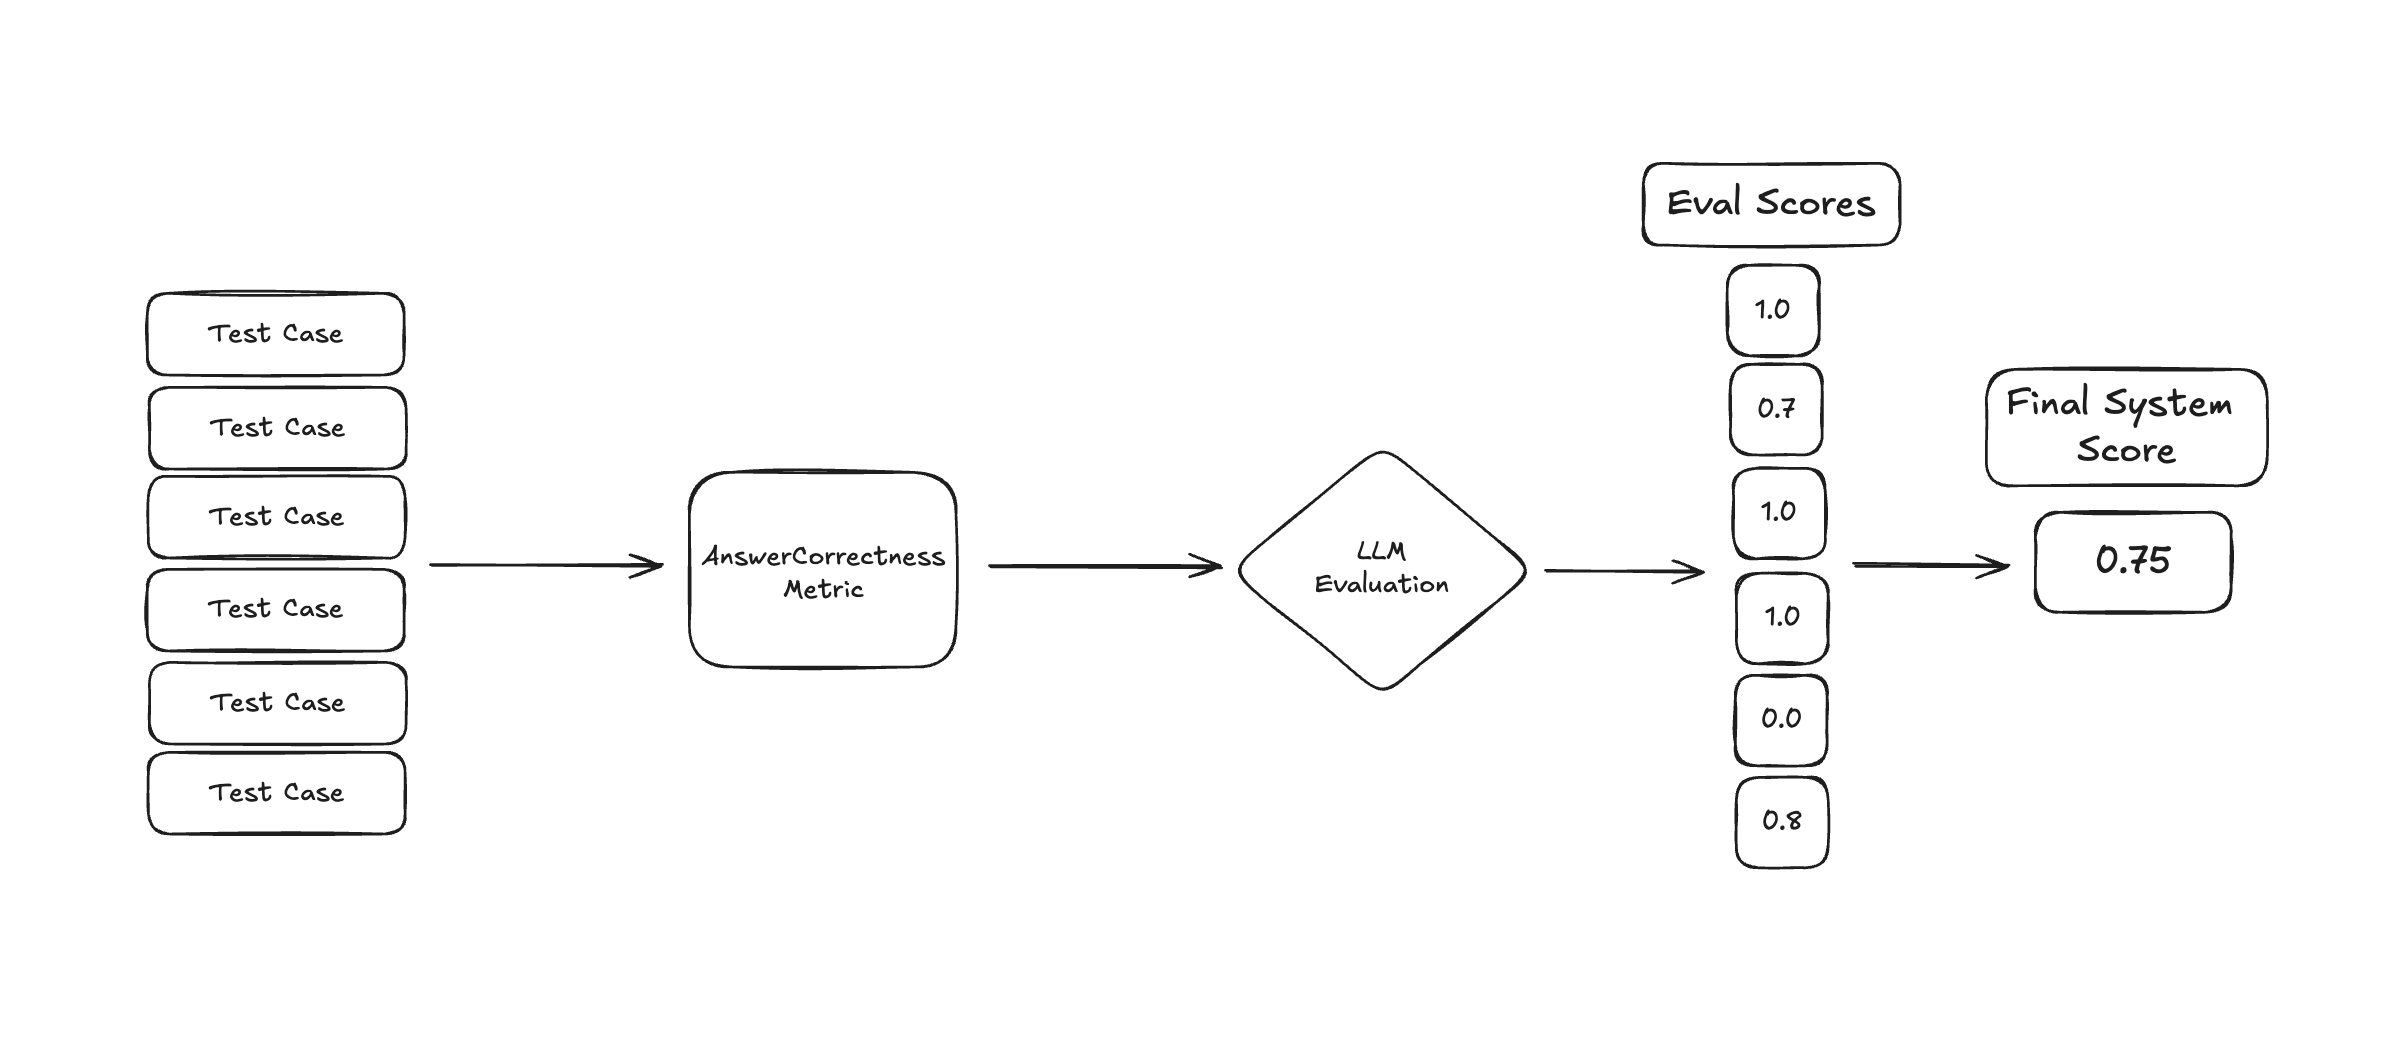

### 1 - Test Cases

Executing an evaluation using DeepEval requires three components: 
1. An evaluation LLM (preferably a higher-end LLM like `gpt-4o`).  **Keep in mind, this is an evaluation LLM, not to be confused with the RAG system Reader model - `gpt-4o-mini`.**
2. An evaluation metric (in this case Answer Correctness)
3. A test case, defined as a `LLMTestCase` Class in DeepEval. A test case is simply an organizational structure for passing in the relevant information that the evalaution LLM needs to measure the metric.  In this case, we will be passing in the `input` (query), the `actual_output` (response from our reader LLM), and the `retrieval_context` (the retrieved context from our search results).
4. The Evaluation LMM will review the input/query and determine if the answer/actual_output from the Reader LLM is correct based on the information found in the retrieval context. 

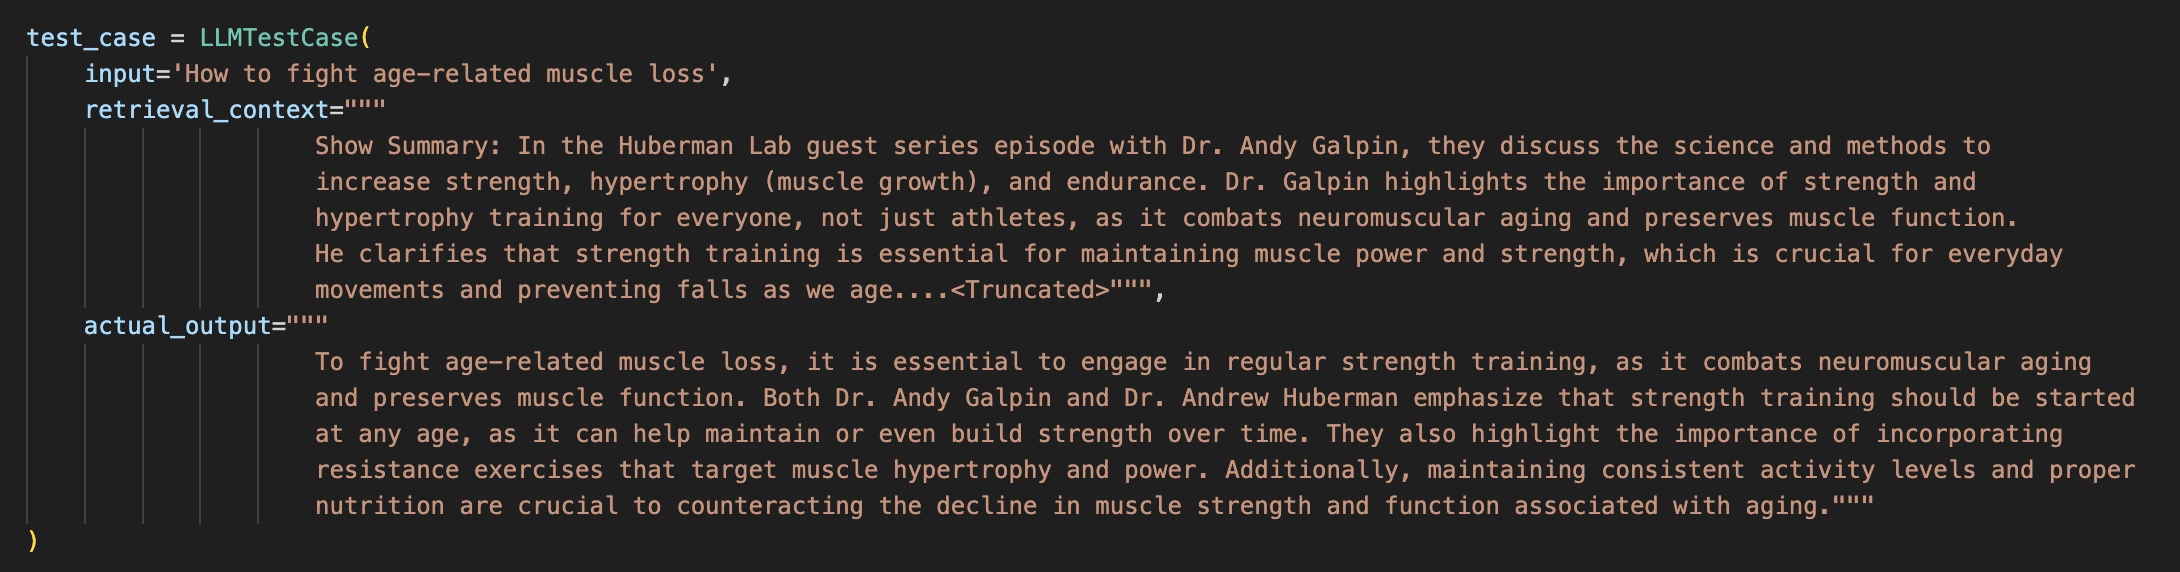

### 2 - Metric: Answer Correctness
As referenced in the Week 2 Course Content (LLM Evaluation sections), before we evaluate anything we have to decide what we are going to measure. There are several LLM evaluation metrics that we can choose from.  However, in my opinion, it's best to start simple, so we'll use the most basic and intuitive metric, `AnswerCorrectness` which addresses the fundamental question of "Did the LLM produce the correct answer (given the context)?".  

#### Evaluation Steps
As a recap, the AnswerCorrectness metric is a prompt fed into an Evaluation LLM that adheres to the following evaluation steps, after receiving the RAG pipeline query, context, and answer/actual_output:
   * Compare the actual output with the retrieval context to verify factual accuracy.
   * Assess if the actual output effectively addresses the specific information requirement stated in the input.
   * Determine the comprehensiveness of the actual output in addressing all key aspects mentioned in the input.
   * If there is not enough information in the retrieval context to correctly answer the input, and the actual output indicates that the input cannot be answered with the provided context, then the score should be 1.

#### Metric Threshold
Though not required, we can pass a threshold float value into the AnswerCorrectness metric, which allows us to set the conditions for what is considered a successful response or not.  As you'll see, determining whether an LLM correctly answered a question or not (particularly a question with multiple components), is not as straightfoward as you might initially think.  Because we are asking the model to score the response with a value between 0 and 1 this implies that there is a **range** of potential outcomes.  `threshold` allows us to draw a line in the sand where values below the threshold are considered incorrect and vice versa.  The default threshold value for AnswerCorrectness is `0.8` but can be adjusted depending on your use case. 


💥 Enough chat, let's see the code.  💥

In [ ]:
from deepeval.test_case import LLMTestCase
from src.evaluation.llm_evaluation import AnswerCorrectnessMetric

##### 1. Create a Test Case from the previous query results
**Quick Note**: Because the keys of the `llm_response` are intentionally the same as the parameter names in the `LLMTestCase` Class we can unpack the dictionary directly using the `**` operator. 

In [ ]:
#build a Test Case using the previous llm_response
test_case = LLMTestCase(**llm_response)  # <--- Same things as doing this: test_case = LLMTestCase(llm_response["input"], 
                                                                                                #  llm_response["retrieval_context"], 
                                                                                                #  llm_response["acutal_output"])

##### 2. Instantiate a metric by passing in the Evaluation model name (string)

In [ ]:
#metric takes in an evaluation LLM of our choice as a string
evaluation_llm = 'gpt-4o'
ac_metric = AnswerCorrectnessMetric(evaluation_llm)

#view the evaluation steps that go into the custom AnswerCorrectness metric
ac_metric.evaluation_steps

<div class="alert alert-danger"><h5>WARNING - Executing the `measure` function will trigger a call to the LLM that you passed into the `AnswerCorrectnessMetric`.  In this case it's only a single LLM call, so the cost will be minimal, but other metrics in the DeepEval library make multiple LLM calls under the hood...</h5></div>  

##### 3. Execute the AnswerCorrectness evaluation by calling the `measure` function


In [ ]:
#you will likely see a nest_asyncio patching message
ac_metric.measure(test_case, _show_indicator=False)

##### 4. View the `metric` object, pay particular attention to:
- `evaluation_cost` - Cost of running the evaluation test
- `reason` - Reasoning behind the score provided by the evaluation LLM
- `score` - The score result from the evaluation test (as determined by the evaluation LLM)

In [ ]:
print(f'Cost: ${ac_metric.evaluation_cost:.2f}')
print(f'Reason: {ac_metric.reason}')
print(f'Score: {ac_metric.score:.2f}')

In [ ]:
# view entire metric object
# print(ac_metric.__dict__)

##### 5. A better way to view the metric data, to include the contextual data associated with the test case is to use the `load_eval_response` function
- Puts the most important information on the top
- Includes the `input`, `actual_output`, and `retrieval_context` data for reference

In [ ]:
from src.evaluation.llm_evaluation import load_eval_response 

eval_response = load_eval_response(ac_metric, test_case, return_context_data=True)
print(eval_response)

### Scoring Model Responses with inadequate context 
If we take a look at the evaluations steps from our metric (`ac_metric.evaluation_steps`), you'll note that the last step instructs the evaluation LLM to score a 10 (which turns into a 1.0 when output) if the `actual_output` states that it **cannot answer the question given the context if the context does not provide enough information to answer the user question.**  We don't want to assign a score of 0 here, becuase the reader model is doing the right thing by stating it cannot answer the question, as opposed to making something up.  Let's see if the evaluation model correctly assigns a score of 1.0 to queries where I know the answers aren't present in the context. 

In [ ]:
fake_queries = [ "What are Musk's exact plans for taking over Mars", 
                 "What is Andrew Huberman's middle name", 
                 "How long do you think Peter Attia will live"
               ]

In [ ]:
#this will make three calls to your designated reader model
answer_bundles = [pipe(q) for q in tqdm(fake_queries)]

In [ ]:
# print(answer_bundles)

##### RUNNING THE TEST BELOW TOOK ME 7 SECONDS AND COST 1 CENT

In [ ]:
%%time

# iterate over the answer_bundles and view the responses
responses = []
for bundle in answer_bundles:
    
    #create a test case
    test_case = LLMTestCase(**bundle)
    
    #execute an AnswerCorrectness measure
    ac_metric.measure(test_case, _show_indicator=False)
    
    #aggregate results + include retrieved context
    responses.append(load_eval_response(ac_metric, test_case, return_context_data=True))
     

In [ ]:
cost = sum([r.cost for r in responses])
scores = [r.score for r in responses]
reasons = [r.reason for r in responses]
overall_eval_score = sum(scores)/len(scores)

##### Assuming your evaluation LLM is doing it's job correctly you should see scores of 1 (or close to 1) for each response

In [ ]:
print(f'Cost: ${cost:.2f}\n\nScores: {scores}\n\nReasoning: {reasons}\n\nOverall Score: {overall_eval_score}')

# Assignment 2.4 - LLM Generation Evaluation Baseline

#### *Get a baseline LLM Generation Evaluation, using a pre-defined dataset of queries*
1. Start by creating a series of Test Cases using the `create_test_cases` function:
   - Iteratate over queries (wrap with `tqdm`)
   - Generate an answer bundle using your previously defined `RAGPipeline`
   - Wrap the answer bundle as an `LLMTestCase` and append to `test_cases`.  
   - Finally, import the pre-defined queries from `path_to_queries` and execute your function to generate the test cases. 
2. Complete the `generation_evaluation` function by writing exactly four lines of code: 
   - **Line #1**: Iterate over the `test_cases` (wrap with `tqdm`)
   - **Line #2**: For each test case instantiate a new `AnswerCorrectness` metric (be sure to pass in the correct args) as a variable named `ac_metric`
   - **Line #3**: Call the `measure` method on `ac_metric` and set the `_show_indicator` param to `False` (prints unecessary output if you don't)
   - **Line #4**: Append `ac_metric` to your `evaluations` list
3. Finally, execute your baseline `generation_evaluation` by passing in your previously created test_cases and the `generation_config` from your `RAGPipeline` (see example of the config below).
4. Submit your 

### 1. Create Test Cases from pre-defined queries

In [ ]:
from deepeval.test_case import LLMTestCase
from src.preprocessor.preprocessing import FileIO


# Define function to create a series of 20 Test Cases
def create_test_cases(queries: list[str], rag_pipe: RAGPipeline) -> list[LLMTestCase]:
    """Iterates over a list of queries and calls LLM through a RAG pipeline 
    to generate an answer bundle and formats output as an LLMTestCase."""
    
    test_cases = []
    #################
    ##  START CODE ##
    #################
    
    return test_cases


# path to pre-defined queries
path_to_queries = '../data/golden_datasets/llm_eval_queries.json'

queries = FileIO.load_json(None)
llm_test_cases = create_test_cases(None, None)

    #################
    ##  END CODE   ##
    #################

Double-check to see that you have correctly formatted Test Cases with:
- `input`, `actual_output` and `retrieval_context` entries
- You can safely ignore any other `LLMTestCase` parameters


In [ ]:
# print(llm_test_cases[0])

<details>
    <summary>
        Click to see what running the above line should look like
    </summary>
    
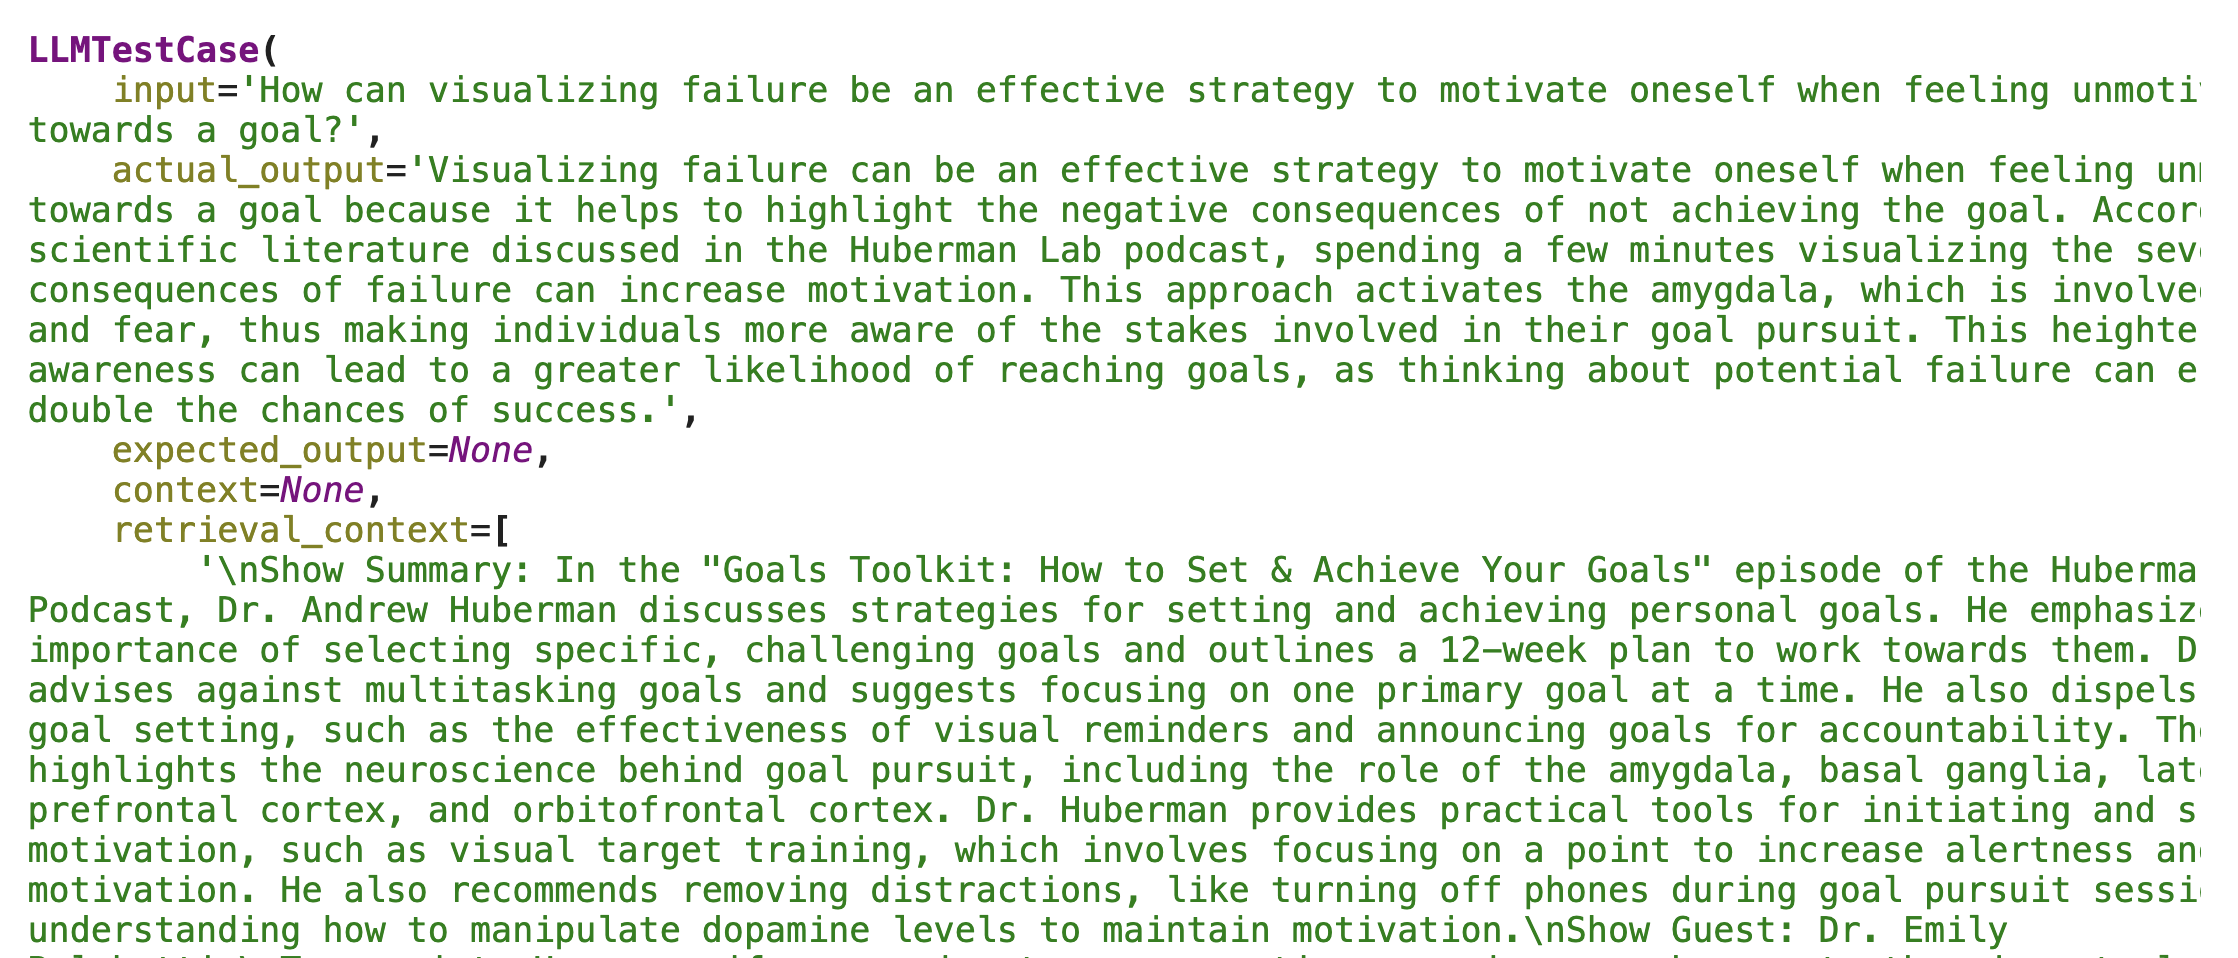
</details>

### 2. Define Generation Evaluation function

In [18]:
from src.data_models import GenerationEvaluation
from src.evaluation.llm_evaluation import AnswerCorrectnessMetric, load_eval_response
from notebook5_helpers import get_model_name, get_model_cost

from deepeval.models.base_model import DeepEvalBaseLLM
from deepeval.test_case import LLMTestCase
from tqdm import tqdm
    
def generation_evaluation(test_cases: list[LLMTestCase],
                          generation_config: dict,
                          evaluation_llm: str | DeepEvalBaseLLM = 'gpt-4o',
                          eval_threshold: float=0.8,
                          context_chunk_size: int=256,
                          context_chunk_overlap: int=0
                          ) -> GenerationEvaluation:
    '''
    Execute bulk evaluation of test cases with a defined metric.
    '''
    generation_eval = GenerationEvaluation(**generation_config,
                                           eval_model=get_model_name(evaluation_llm),
                                           context_chunk_size=context_chunk_size,
                                           context_chunk_overlap=context_chunk_overlap,
                                           small_to_big=False)
    
    #################
    ##  START CODE ##
    #################
    evaluations = []
    
    ### write your four lines of code here: ###
    
        
    #################
    ##  END CODE   ##
    #################

    # parse metric responses into a list of EvalResponse objects
    eval_responses = [load_eval_response(response, data, return_context_data=False) for \
                      response, data in zip(evaluations, test_cases)]
    
    scores = [r.score for r in eval_responses]
    # if using an OpenAI model cost will be a float value, otherwise it will be 'N/A'
    cost = get_model_cost(eval_responses)

    #calculate and assign eval score values to generation_eval object
    generation_eval.eval_score = round(sum(scores)/len(scores),3)
    generation_eval.total_questions = len(scores)
    generation_eval.correct_answers = sum([score >= ac_metric.threshold for score in scores])
    generation_eval.incorrect_answers = generation_eval.total_questions - generation_eval.correct_answers
    
    return {'generation_eval': generation_eval, 'responses': eval_responses, 'scores': scores, 'cost': cost}

### 3. Execute `generation_evaluation`

#### Generation Configuration
You may have noticed when creating your `RAGPipeline` Class earlier in the notebook that there was a `generation_config` attribute.  This config is a way to pass along the reader LLM hyperparameters into your evaluation function.  As discussed throughout this course, the majority of these hyperparameters affect the amount of context that the reader LLM will have available to it during the answer synthesis step of your RAG Pipeline.  These are the knobs and dials that you can tweak to change your generation evaluation score. In the configuration example below you'll note that the `system` and `user` messages are themselves considered generation hyperparameters because they, of course, contribute greatly to the reader LLM output.  Likewise the reader LLM is itself a hyperparameter, given that different models will perform better or worse depending on the task. 

<details>
    <summary><strong>Click to see Example Configuration</strong></summary>

```
{
    'reader_model': 'gpt-4o-mini',
    'temperature': 0.5,
    'verbosity': 'concisely',
    'num_context_chunks': 3,
    'system_message': 'You are a repository of knowledge and wisdom about the Huberman Lab podcast.\nThe Huberman Lab podcast is hosted by Dr. Andrew Huberman, a neuroscientist and tenured professor of neurobiology and ophthalmology at Stanford School of Medicine. The podcast discusses neuroscience and science-based tools, including how our brain and its connections with the organs of our body control our perceptions, our behaviors, and our health, as well as existing and emerging tools for measuring and changing how our nervous system works. The podcast is frequently ranked in the top 10 of all podcasts globally and is often ranked #1 in the categories of Science, Education, and Health & Fitness.\nYour task is to answer questions about the Huberman Lab podcast only using the context provided in the user message.\nOnly use the context provided to answer the question. Do not use any external knowledge or resources to answer the question.',
    'user_message': 'Your task is to synthesize and reason over a series of transcripts of an interview between Andrew Huberman and his guest(s).\nAfter your synthesis, use the series of transcripts to answer the below question.  The series will be in the following format:\n\n```\nShow Summary: <summary>\nShow Guest: <guest>\nTranscript: <transcript>\n```\n\nStart 
Series:\n```\n{series}\n```\nQuestion:\n\n{question}\n\n------------------------\n1. If the context does not provide enough information to answer the question, then\nstate that you cannot answer the question with the provided context.\n2. Do not use any external knowledge or resources to answer the question.\n3. Answer the question directly and {verbosity}.\n------------------------\nAnswer:}
```
</details>

In [ ]:
from notebook5_helpers import record_project2_submission

#################
##  START CODE ##
#################

#execute evaluation
response_dict = generation_evaluation(None, None)

#################
##  END CODE   ##
#################

# Do NOT touch these lines of code 
generation_eval = response_dict['generation_eval']
record_project2_submission(generation_eval)

In [ ]:
# view generation evaluation output
print(generation_eval)

# Conclusion
***

We now have a way of measuring the performance of the **Generation** component of our RAG system.  This will allow you to make tweaks/changes to the system and then be able to objectively tell whether or not the tweak/change improved or degraded its performance.  Here are a few things to consider going forward:  
- The easiest parameters to tweak are the `num_context_chunks`, `verbosity` and the model `temperature`.  Try giving the model more context to see if that improves or worsens your evaluation score.
- The `small_to_big` parameter is soemthing we will explore in notebook 7.  You'll see that implementing small-to-big retrieval allows us to retrieval at a more granular level, but present the reader LLM with a larger context window for answer synthesis.
- You could also change your reader model from `gpt-4o-mini` to another OpenAI model and see how it does.  For the adventurous, feel free to use another LLM from an entirely different LLM provider i.e. Anthropic or even an open source variant.  --> You'll likel need to tweak the code to support an Open Source LLM. 
- To get a real feel for how well your system is peforming I recommend trying out the Optional section below where you generate new Test Cases (randomly) and then run a new evaluation.  I recommend generating at least 30 test cases.
---
### \** BREAK ** To go futher in-depth see additional Optional sections below \** BREAK **
---

# *** Optional: Using Custom Evaluation LLMs ***

`DeepEval` provides a way to use evaluation LLMs other than OpenAI models.  Just know that if you do so, cost information is not supported with other models at this time.  CustomClass wrappers have already been written for this course that support Anthropic and Cohere models.  To use them see code examples below. Loading these models assumes you have the following environment variables set:  

**Anthropic**
- `ANTHROPIC_API_KEY`
  
**Cohere**
- `COHERE_API_KEY`

Using a different LLM for evaluation other than an OpenAI model will reveal some interesting differences between the way that other LLMs assess input.  Personally, I have noticed a bias in models from the same LLM provider favoring output from their same model class i.e. `gpt-4o` favoring `gpt-4o-mini` output.  You can draw your own conclusions if you conduct this exercise. 

In [ ]:
from src.evaluation.llm_evaluation import CustomAnthropic, CustomCohere
from src.evaluation.llm_evaluation import AnswerCorrectnessMetric

print(CustomAnthropic.accepted_model_types)
print(CustomCohere.accepted_model_types)

In [ ]:
#instantiate Custom DeepEval LLMs like so
sonnet = CustomAnthropic('claude-3-sonnet-20240229')
command_plus = CustomCohere('command-r-plus')

# the custom model can then be passed as the evaluation_model arg to AnswerCorrectnessMetric 
# to use with evaluations
ac_metric = AnswerCorrectnessMetric(evaluation_model=sonnet)

# if using with the generation_evaluation function
response_dict = generation_evaluation(llm_test_cases[:2], pipe.generation_config, evaluation_llm=sonnet)

<details>
    <summary>Click to see my baseline results from Anthropic's Opus model.</summary>

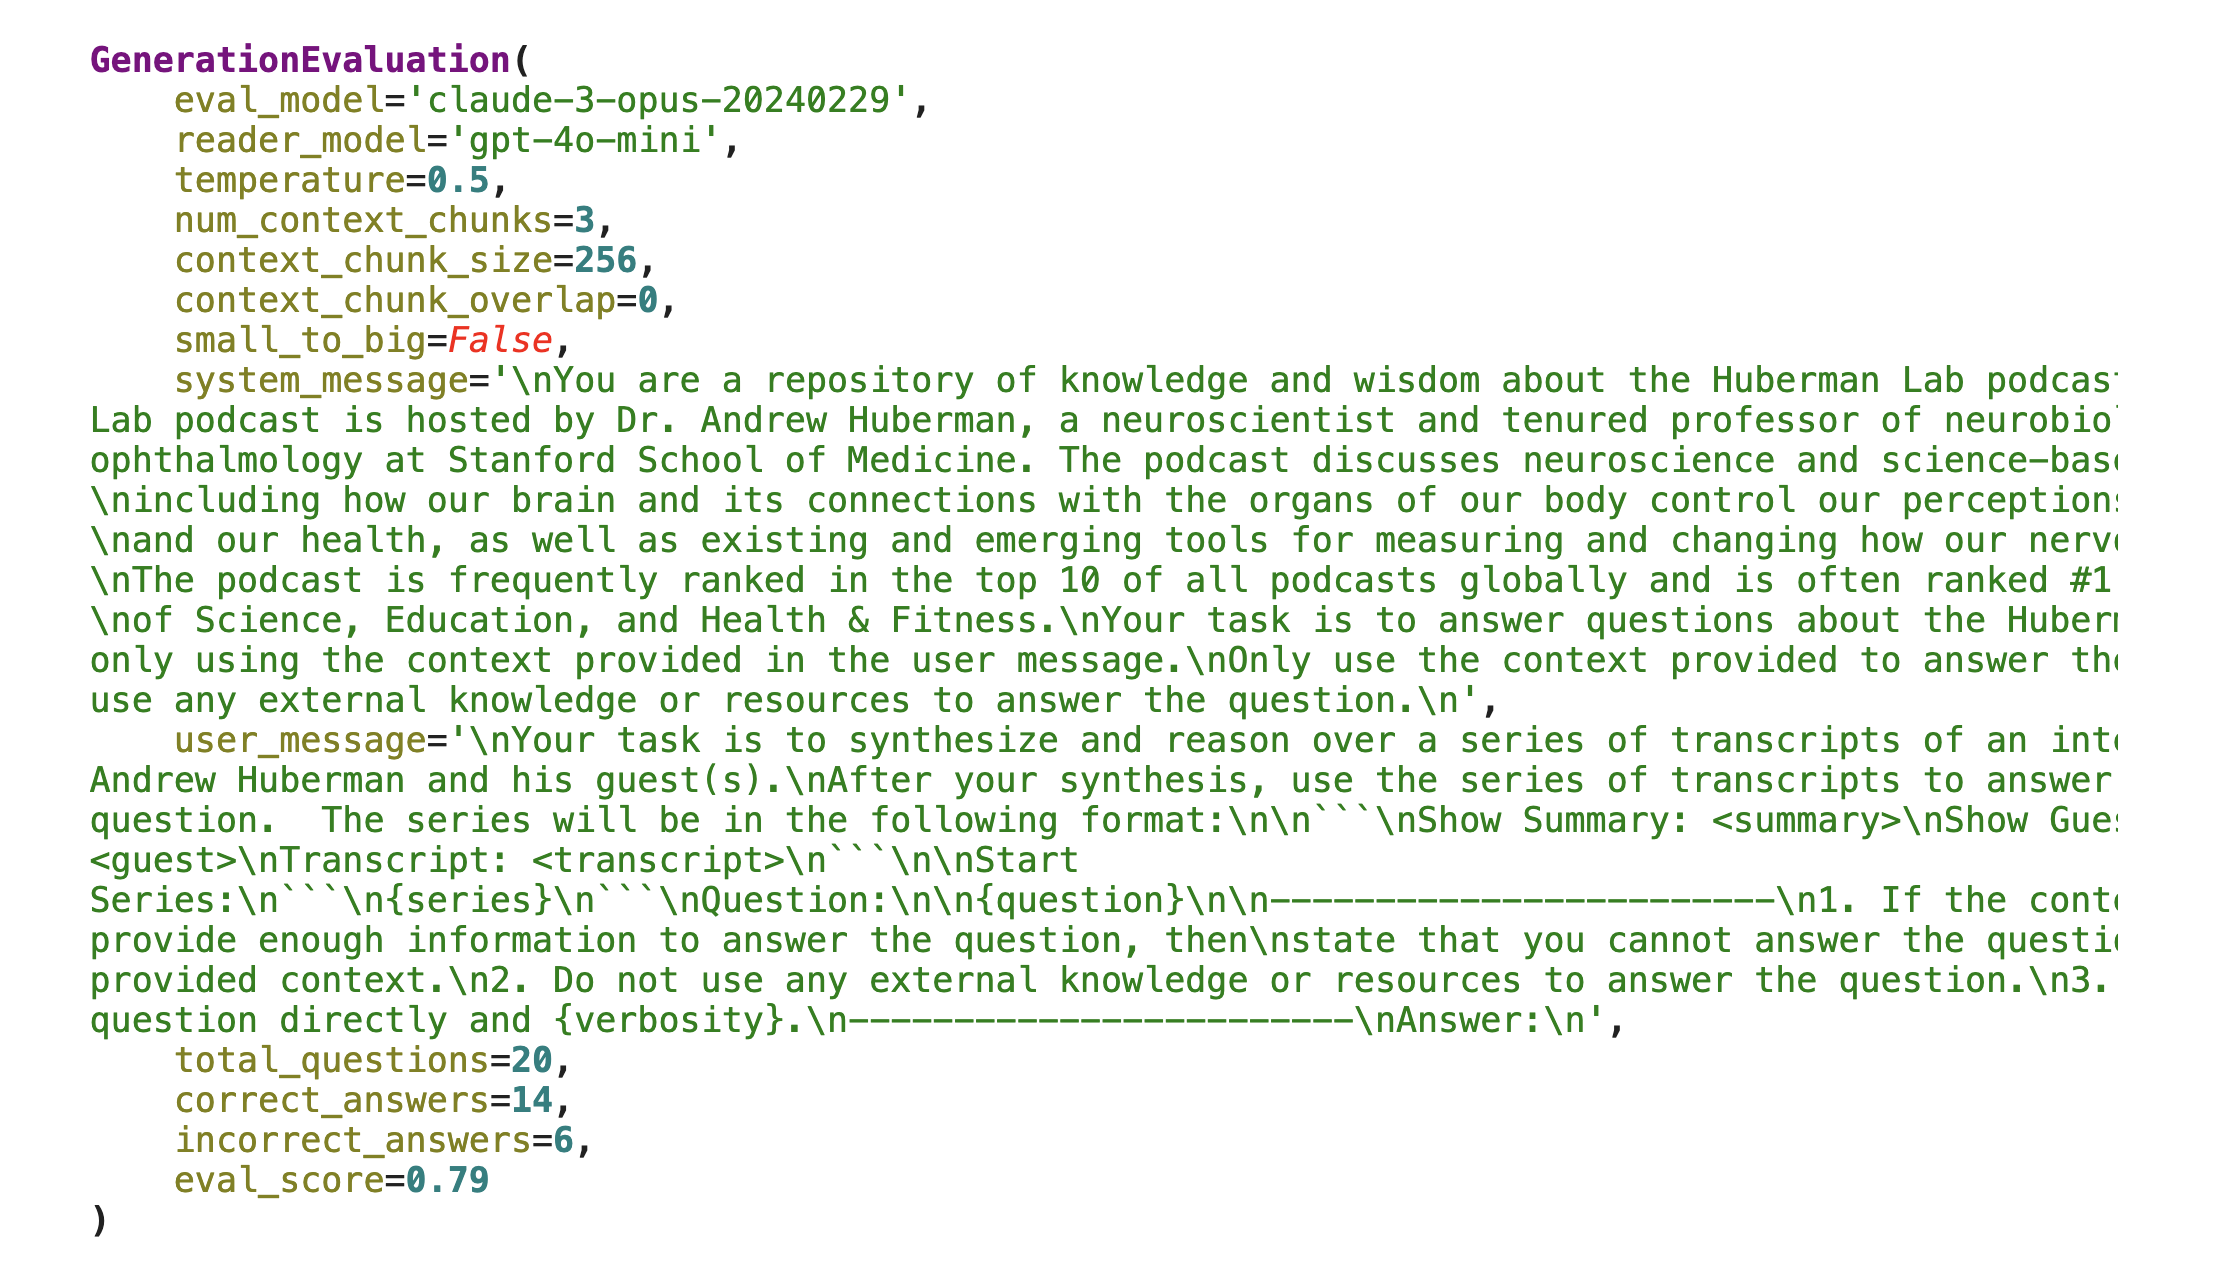 

#### It appears that compared with OpenAI gpt-4o from above, Opus is a much harder grader on `gpt-4o-mini` than `gpt-4o`...surprised?  🤡
</details>

# *** Optional: Generating your own Test Cases ***

If you'd like to quickly generate your own Test Cases, I have included a function which will asynchronously make LLM calls to speed up the process. If you plan on using this function, make sure that your LLM Provider Rate Limit will support the amount of Test Cases you want to generate, or submit your calls in fewer batches to avoid the 429 Rate Limit Error.  This is a sample implementation only, but feel free to change the code [in this file:](https://github.com/americanthinker/rag-applications/blob/main/src/evaluation/llm_evaluation.py#L227) `rag-applications/src/evaluation/llm_evaluation.py` if you want to use this functionality as part of your actual LLM evaluations.  

### Set Components

In [ ]:
llm = LLM('gpt-4o-mini')
retriever = WeaviateWCS(os.environ['WEAVIATE_ENDPOINT'], os.environ['WEAVIATE_API_KEY'])
reranker = ReRanker()

In [ ]:
#instantiate the TestCaseGenerator
from src.evaluation.llm_evaluation import TestCaseGenerator
tcg = TestCaseGenerator(llm, retriever, reranker)

### Get Queries
The data needed to generate test cases is a list of queries.  You can either generate these manually or use an LLM to generate them for you.  In this example, I am grabbing the queries from one of the available golden datasets.  

In [ ]:
data_path = '../data/golden_datasets/golden_512.json'
data = FileIO.load_json(data_path)
queries = list(data['queries'].values())
print(queries[:5])
print(f'Total of {len(queries)} queries.')

In [ ]:
# decide how many test cases you want to create
thirty_queries = queries[:30]

#### Create Test Cases
Executing the `acreate_test_cases` function performs the following operations under the hood:
- Retrieves context for the queries submitted.
- Reranks them using the ReRanker
- Passes that context to the LLM to generate an answer to the query (this step is performed asynchronously)
- Loads all information, input, actual_output, and retrieval_context into a LLMTestCase bundle and returns a list of `LLMTestCases`

In [ ]:
#import timer function to show how quick this can be when using async
from unitesting_utils import timer

with timer():
    generated_test_cases = await tcg.acreate_test_cases(thirty_queries[:1], 'Huberman_minilm_256', 100)